In [19]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = pd.read_parquet("../data/matches.parquet")

In [21]:
df = df.dropna()

In [22]:
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 2016 entries, 0 to 2019
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   round             2016 non-null   object        
 1   match_date        2016 non-null   datetime64[ns]
 2   home_team         2016 non-null   object        
 3   guest_team        2016 non-null   object        
 4   stadium           2016 non-null   object        
 5   date_added        2016 non-null   datetime64[ns]
 6   score_home_team   2016 non-null   Int64         
 7   score_guest_team  2016 non-null   Int64         
 8   winning_team      2016 non-null   object        
dtypes: Int64(2), datetime64[ns](2), object(5)
memory usage: 161.4+ KB
      round          match_date  home_team     guest_team         stadium  \
0  Rodada 1 2020-08-08 19:00:00  Fortaleza   Athletico-PR   Castelão (CE)   
1  Rodada 1 2020-08-08 19:30:00   Coritiba  Internacional   Couto Pereira   
2  

In [23]:
df['home_wins'] = (df['winning_team'] == 'home').astype(int)

In [24]:
def get_previous_matches(team, date, n=10):
    # Get all matches where the team participated (home or away) before the given date
    team_matches = df[((df['home_team'] == team) | (df['guest_team'] == team)) & 
                     (df['match_date'] < date)].sort_values('match_date', ascending=False)
    
    # Take the most recent n matches
    recent_matches = team_matches.head(n)
    
    # Prepare the data for each match
    match_data = []
    for _, row in recent_matches.iterrows():
        if row['home_team'] == team:
            # Team was home
            goals_scored = row['score_home_team']
            goals_conceded = row['score_guest_team']
            home_away = 1  # 1 for home
        else:
            # Team was away
            goals_scored = row['score_guest_team']
            goals_conceded = row['score_home_team']
            home_away = 0  # 0 for away
            
        match_data.append([goals_scored, goals_conceded, home_away])
    
    # If less than n matches, pad with zeros
    while len(match_data) < n:
        match_data.append([0, 0, 0])
    
    return match_data

In [25]:
# Sort by match date to ensure chronological order
df = df.sort_values('match_date')

# Initialize lists to store samples
X = []
y = []

# Iterate through each match to create samples
for idx, row in df.iterrows():
    # Get previous matches for home team
    home_team_data = get_previous_matches(row['home_team'], row['match_date'])
    
    # Get previous matches for guest team
    guest_team_data = get_previous_matches(row['guest_team'], row['match_date'])
    
    # Combine the data (first 5 rows home team, next 5 rows guest team)
    sample = home_team_data + guest_team_data
    
    # Add to our dataset
    X.append(sample)
    y.append(row['home_wins'])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Verify the shape
print(X.shape)  # Should be (num_matches, 10, 3)
print(y.shape)  # Should be (num_matches,)

(2016, 20, 3)
(2016,)


In [26]:
class MatchPredictor(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=2, dropout=0.3):
        super(MatchPredictor, self).__init__()
        
        # LSTM to process each team's match sequence
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # x shape: (batch_size, 20, 3)
        # Split into home and away team sequences
        home_seq = x[:, :10, :]  # (batch_size, 10, 3)
        away_seq = x[:, 10:, :]  # (batch_size, 10, 3)
        
        # Process home team sequence
        home_out, _ = self.lstm(home_seq)
        home_attn = self.attention(home_out).softmax(dim=1)
        home_embedding = (home_out * home_attn).sum(dim=1)
        
        # Process away team sequence
        away_out, _ = self.lstm(away_seq)
        away_attn = self.attention(away_out).softmax(dim=1)
        away_embedding = (away_out * away_attn).sum(dim=1)
        
        # Concatenate both team embeddings
        combined = torch.cat([home_embedding, away_embedding], dim=1)
        
        # Final prediction
        output = self.fc(combined)
        return output.squeeze()

In [27]:
def train_model(X, y, epochs=20, batch_size=32, learning_rate=0.001):
    # Convert numpy arrays to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    
    # Create dataset and split into train/validation
    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss, and optimizer
    model = MatchPredictor()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        # Print statistics
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        accuracy = correct / total
        
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {accuracy:.4f}')
    
    return model

# Example usage:
# model = train_model(X, y)


Training Model...
Epoch 1/20 - Train Loss: 0.6902 - Val Loss: 0.6920 - Val Acc: 0.5232
Epoch 2/20 - Train Loss: 0.6866 - Val Loss: 0.6850 - Val Acc: 0.5232
Epoch 3/20 - Train Loss: 0.6762 - Val Loss: 0.6759 - Val Acc: 0.6037
Epoch 4/20 - Train Loss: 0.6701 - Val Loss: 0.6763 - Val Acc: 0.6068
Epoch 5/20 - Train Loss: 0.6702 - Val Loss: 0.6738 - Val Acc: 0.6099
Epoch 6/20 - Train Loss: 0.6689 - Val Loss: 0.6726 - Val Acc: 0.6161
Epoch 7/20 - Train Loss: 0.6699 - Val Loss: 0.6751 - Val Acc: 0.6130
Epoch 8/20 - Train Loss: 0.6700 - Val Loss: 0.6774 - Val Acc: 0.5882
Epoch 9/20 - Train Loss: 0.6723 - Val Loss: 0.6729 - Val Acc: 0.6099
Epoch 10/20 - Train Loss: 0.6668 - Val Loss: 0.6729 - Val Acc: 0.6006
Epoch 11/20 - Train Loss: 0.6683 - Val Loss: 0.6731 - Val Acc: 0.6223
Epoch 12/20 - Train Loss: 0.6673 - Val Loss: 0.6715 - Val Acc: 0.6254
Epoch 13/20 - Train Loss: 0.6670 - Val Loss: 0.6712 - Val Acc: 0.6223
Epoch 14/20 - Train Loss: 0.6675 - Val Loss: 0.6723 - Val Acc: 0.6285
Epoch 15/2

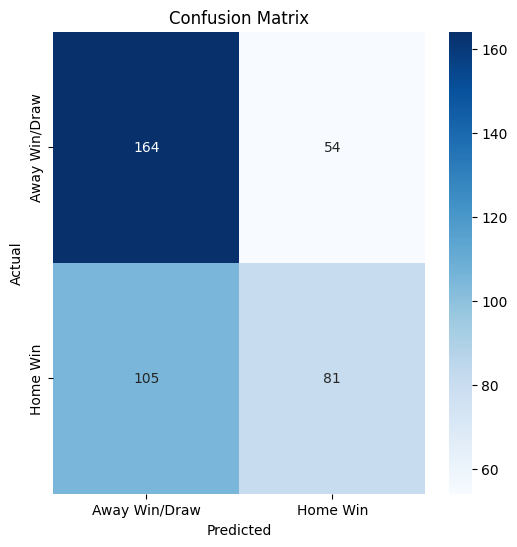

In [28]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, batch_size=32):
    """Evaluate the model using scikit-learn's classification report"""
    # Convert to tensors
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create test dataset and loader
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Get predictions
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = (outputs > 0.5).float()  # Threshold at 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Generate comprehensive classification report
    print("\n" + "="*60)
    print("Classification Report:")
    print("="*60)
    print(classification_report(
        all_labels, 
        all_preds, 
        target_names=['Away Win/Draw', 'Home Win'],
        digits=4
    ))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Away Win/Draw', 'Home Win'],
        yticklabels=['Away Win/Draw', 'Home Win']
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate(X, y, test_size=0.2, epochs=20, batch_size=32, lr=0.001):
    """Complete training and evaluation pipeline"""
    # Split into train+val and test sets
    from sklearn.model_selection import train_test_split
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=42,
        stratify=y  # Maintain class distribution
    )
    
    # Train the model using your existing function
    print("\n" + "="*60)
    print("Training Model...")
    print("="*60)
    model = train_model(
        X_train_val, 
        y_train_val, 
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=lr
    )
    
    # Evaluate on test set
    print("\n" + "="*60)
    print("Evaluation Results:")
    print("="*60)
    evaluate_model(model, X_test, y_test, batch_size=batch_size)
    
    return model

# Example usage:
model = train_and_evaluate(X, y, epochs=20, batch_size=64, lr=0.001)

In [30]:
def predict_new_matches(model, df, home_team, away_team, match_date, n=10):
    """
    Predicts the probability of home win for new matches using historical data
    
    Args:
        model: Trained PyTorch model
        df: DataFrame containing historical match data
        home_team: Name of home team
        away_team: Name of away team
        match_date: Date of the match to predict
        n: Number of historical matches to consider (default=10)
        
    Returns:
        Probability of home win (0-1)
    """
    # Get previous matches for both teams
    home_team_data = get_previous_matches(home_team, match_date, n)
    away_team_data = get_previous_matches(away_team, match_date, n)
    
    # Combine into single sample (first n home, next n away)
    sample = home_team_data + away_team_data
    
    # Convert to numpy array and add batch dimension
    sample_array = np.array([sample])  # shape (1, 20, 3)
    
    # Convert to tensor
    sample_tensor = torch.FloatTensor(sample_array)
    
    # Predict
    model.eval()
    with torch.no_grad():
        probability = model(sample_tensor).item()
    
    return probability

# Example usage:
# Assuming you have:
# - A trained model (model)
# - Your match dataframe (df)
# - New match to predict

# Example prediction:
home_team = "Santos"
away_team = "Flamengo"
match_date = "16/07/2025"  # Must be after all historical matches

prob = predict_new_matches(model, df, home_team, away_team, match_date)
print(f"Probability of {home_team} winning at home against {away_team}: {prob:.1%}")

Probability of Santos winning at home against Flamengo: 26.6%
